# King County House Exploratory Data Analysis

<img src="data/zhifei-zhou-Seattle.jpg">

<hr style="border:2px solid black">

## 1. Introduction

Our client wants to buy a property in King County. She is socially responsible and wants to invest in poor neighborhoods, buying & reselling, while keeping costs to the minimum and making little profit.

By exploring the database, what would be our recommendations to them?

We decide that our analysis objectives are: 
- Identify poor income areas
- Be within size range of neighborhood
- Deﬁne reasonable proﬁt margin

### Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import wrangler, cramers_corrected_stat, anova_pvalue
import plotly.express as px
import missingno as msno 
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 50) 

## 2. Primary Data Examination & Cleaning

Loading & examining the data

In [4]:
df = pd.read_csv('data/eda.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

Getting an overview of the NaN values.

<Axes: >

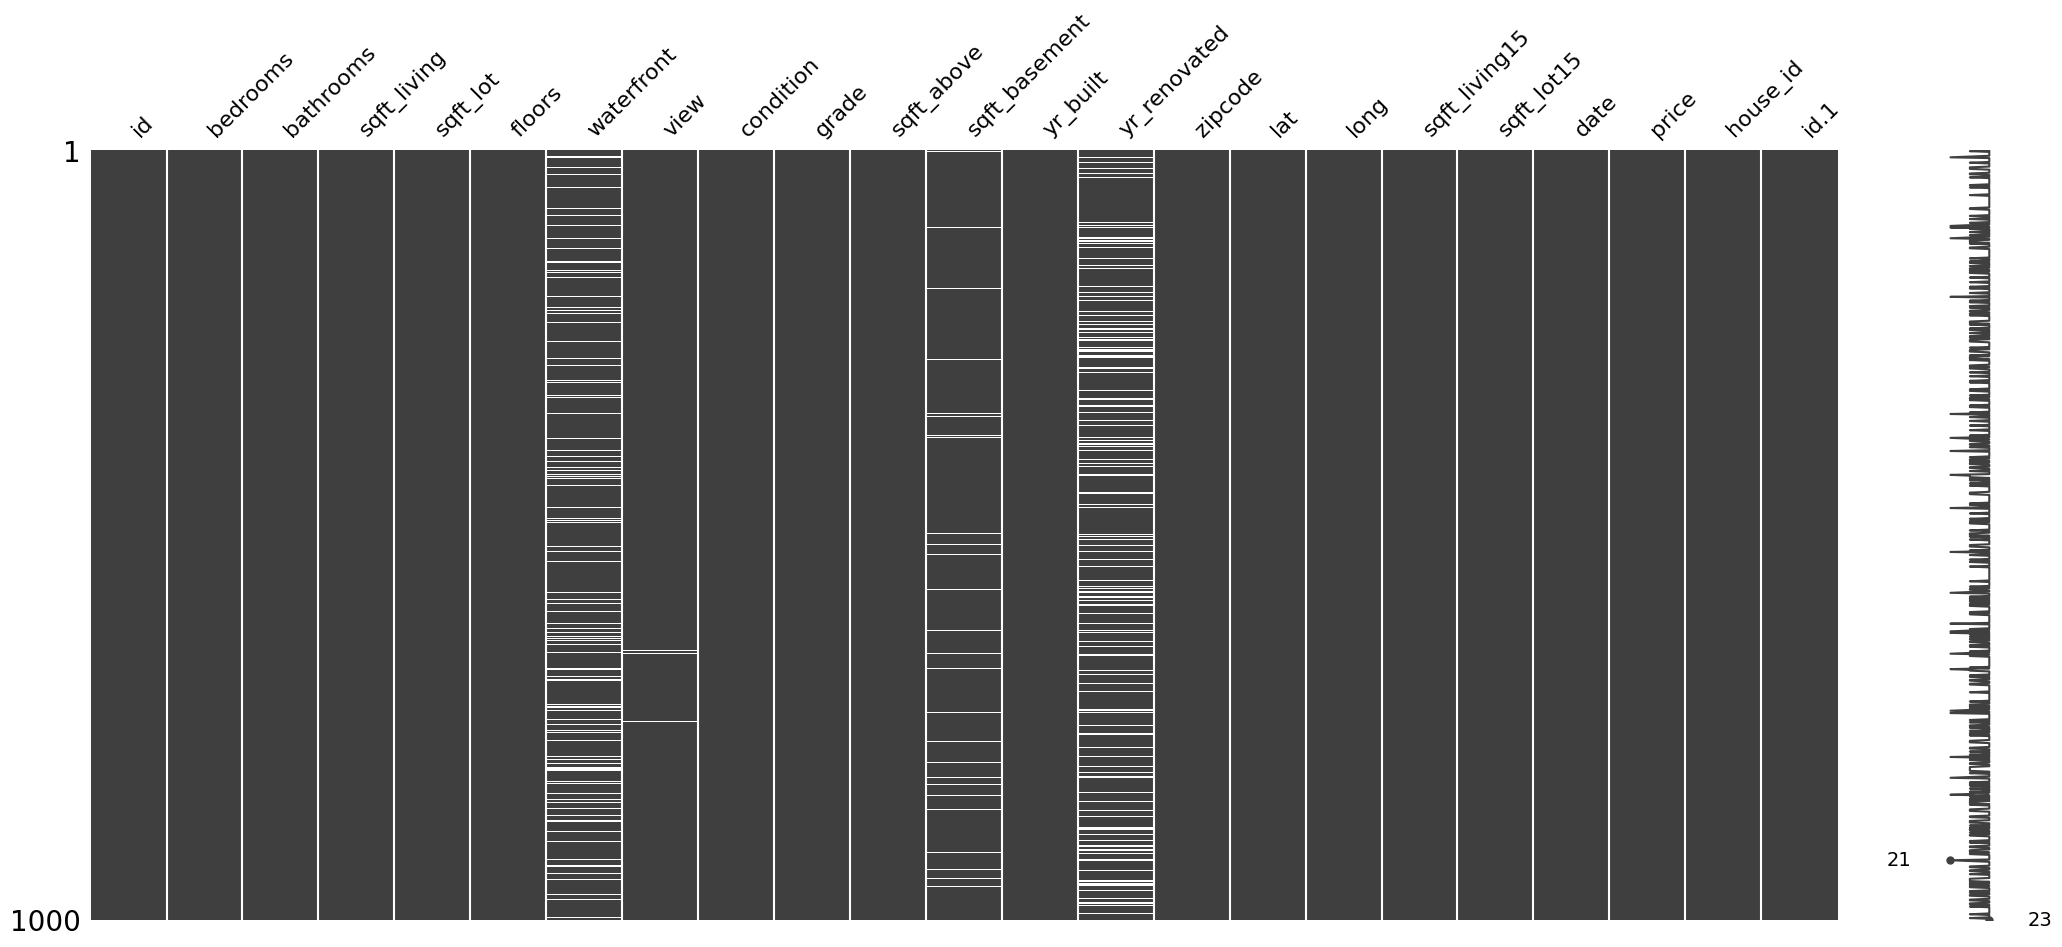

In [6]:
msno.matrix(df.sample(1000))

The percentage of missing or zero values on the renovated dates:

In [7]:
round(df.query('yr_renovated== "NaN" or yr_renovated==0 ').count()['yr_renovated'] / df.shape[0] *100)

79

Duplicate values:

In [8]:
df.id.duplicated().sum()

177

Using the user defined function 'wrangler' to clean and enhance the dataset according to the following specifications:

- Convert to datetime and int accordingly.
- Keeping the duplicated id values , they will be useful for later analysis.
- Substitute the NaN in yr_renovated as 0, since 0 is anyway the majority of data.
- Deduct NaN basement footage from rest area info.
- Waterfront not relevant to client, therefore the corresponding column is excluded.
- View is also excluded as 19k of 21k data is 0 and not relevant to our client.
- Add lat_long tuple column and center_distance columns calculating each property distance from Seattle center. Unit is miles.
- Reordering columns according to our project priorities.

In [9]:
clean_df = wrangler(df)

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   price            21597 non-null  int64         
 1   price_per_sqft   21597 non-null  int64         
 2   sqft_living      21597 non-null  int64         
 3   grade            21597 non-null  int64         
 4   condition        21597 non-null  int64         
 5   center_distance  21597 non-null  float64       
 6   bedrooms         21597 non-null  int64         
 7   bathrooms        21597 non-null  float64       
 8   floors           21597 non-null  float64       
 9   sqft_lot         21597 non-null  int64         
 10  sqft_above       21597 non-null  int64         
 11  sqft_basement    21597 non-null  int64         
 12  sqft_living15    21597 non-null  int64         
 13  sqft_lot15       21597 non-null  int64         
 14  yr_built         21597 non-null  int64

## 3. Exploratory Data Analysis

### 3.1 Correlations

#### Numerical vs numerical

Pearson correlation coefficient

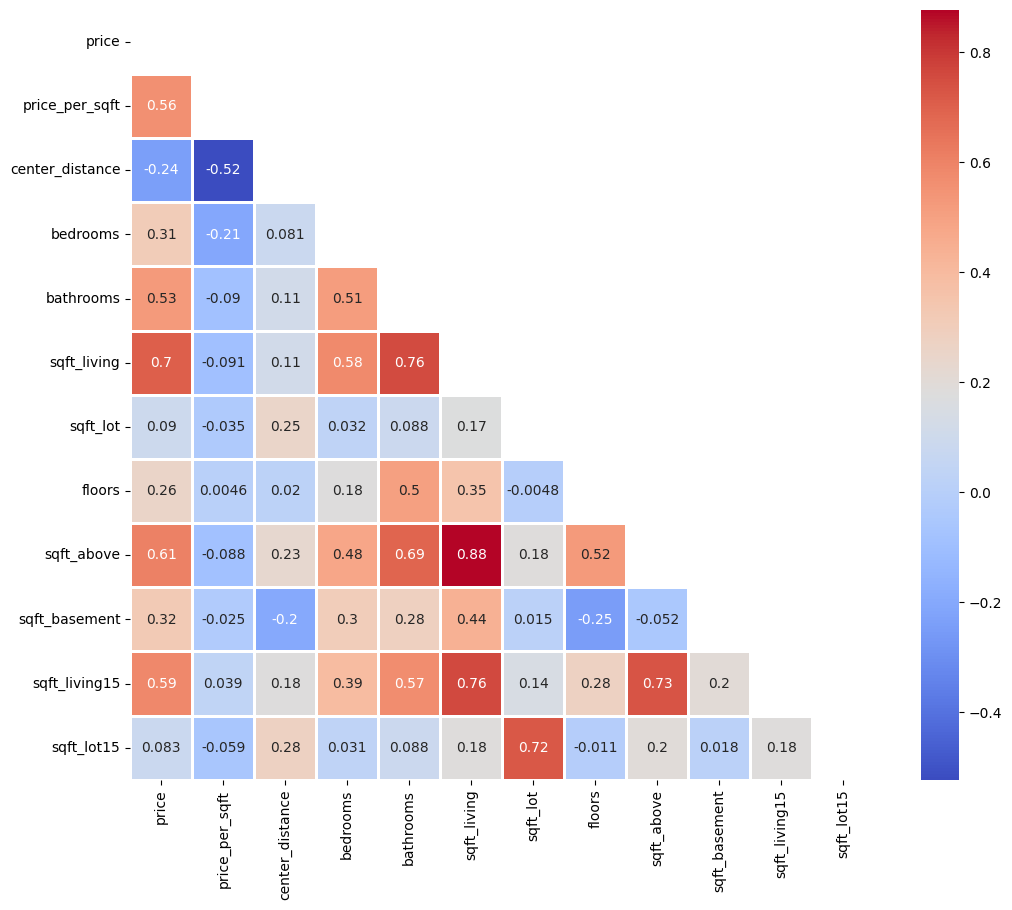

In [11]:
num_feat = ['price','price_per_sqft', 'center_distance','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
pearson_corr = clean_df[num_feat].corr()

mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
plt.figure(figsize=(12,10),dpi=100)
sns.heatmap(data=pearson_corr, mask= mask, cmap='coolwarm', linecolor='white', linewidth=1, annot=True);

As anticipated, the price is strongly correlated to the size of the property, while the price per square foot is mainly correlated to the negative distance from the city center.

The size of the living area and the lot is highly correlated to that of the closest neighbors.

#### Categorical vs categorical 

Cramer's V Test

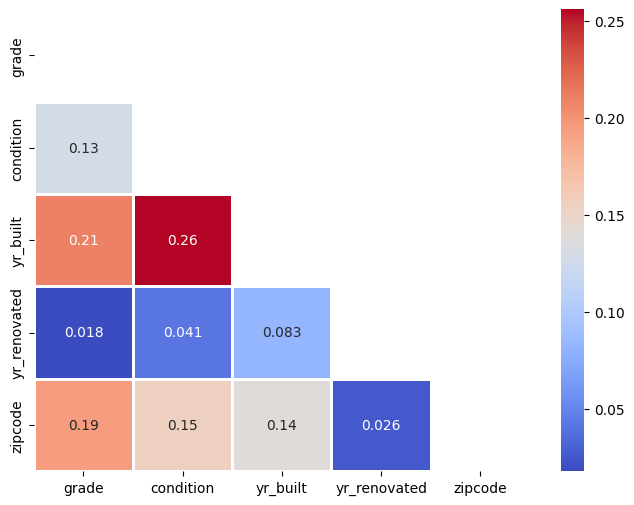

In [12]:
cat_feat = ['grade', 'condition','yr_built', 'yr_renovated','zipcode']
cramer_v_corr = {}
for feat1 in cat_feat:
    cramer_v_corr[feat1] = [cramers_corrected_stat(clean_df,feat1,feat2) for feat2 in cat_feat]
cat_corr = pd.DataFrame(index=cramer_v_corr.keys(),data=cramer_v_corr)

mask = np.triu(np.ones_like(cat_corr, dtype=bool))
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(data=cat_corr, mask=mask, cmap='coolwarm', linecolor='white', linewidth=1, annot=True);

There is moderate association between the grade and condition of the property and the year it was built.

#### Numerical vs categorical

ANOVA testing

In [13]:
for cat in cat_feat:
    for num in num_feat:
        p_value = anova_pvalue(clean_df,cat,num)
        if p_value != 0: 
            print(f"P value of {cat} vs {num}: {p_value}")
print('All rest results have a p value of 0')

P value of yr_renovated vs sqft_lot: 0.61
P value of yr_renovated vs floors: 0.538
P value of yr_renovated vs sqft_above: 0.001
P value of yr_renovated vs sqft_living15: 0.024
P value of yr_renovated vs sqft_lot15: 0.363
All rest results have a p value of 0


Most p values for the ANOVA testing of numerical vs categorical values are zero, pointing to statistical significance in their values being correlated. yr_renovated category results in p values above zero. But this is the category with the 79% NaN or zero values, where the NaN were later imputed as zero's, therefore the results are unreliable on this category.

### 3.2 Distributions

#### Distribution of prices

In [14]:
print(f"Price skew: {round(clean_df.price.skew())}\nPrice kurtosis: {round(clean_df.price.kurtosis())}\nPrice/ft^2 skew: {round(clean_df.price_per_sqft.skew())}\nPrice/ft^2 kurtosis: {round(clean_df.price_per_sqft.kurtosis())}")

Price skew: 4
Price kurtosis: 35
Price/ft^2 skew: 1
Price/ft^2 kurtosis: 2


Price skewness and kurtosis are pointing to a high positive skew and leptokurtosis, indicating extreme outliers. But the price/ft^2 skewness of 1 and a kurtosis of 2 indicate a distribution that is moderately skewed to the right with tails and peakness roughly similar to a normal distribution, but slightly heavier tails. 

Price per square foot will be our value of interest for the investigation.

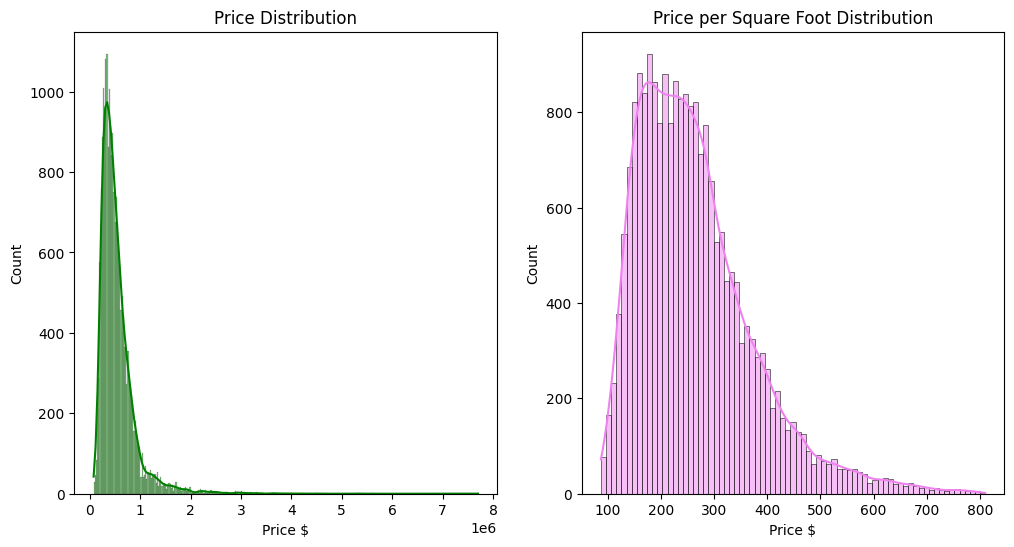

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(clean_df['price'],  kde =True, ax=axs[0], color='green' )
axs[0].set_title('Price Distribution')
axs[0].set_xlabel('Price $')

sns.histplot(clean_df['price_per_sqft'],  kde =True, ax=axs[1] , color='violet')
axs[1].set_title('Price per Square Foot Distribution')
axs[1].set_xlabel('Price $')

# Show the plots
plt.show()

[Text(0, 0.5, 'Price per Sq.Ft.'), Text(0.5, 0, 'Condition')]

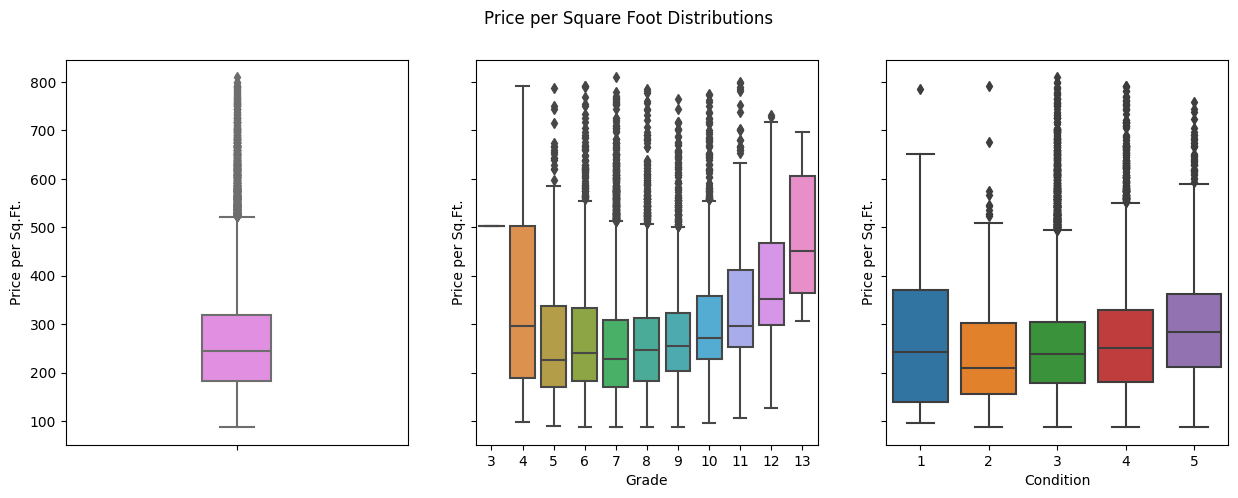

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Price per Square Foot Distributions')


sns.boxplot(ax=axes[0], data = clean_df, y='price_per_sqft', width=0.2, color= 'violet')
axes[0].set( ylabel='Price per Sq.Ft.')


sns.boxplot(ax=axes[1],data = clean_df, y='price_per_sqft', x='grade')
axes[1].set( ylabel='Price per Sq.Ft.', xlabel = 'Grade')

sns.boxplot(ax=axes[2], data = clean_df, y='price_per_sqft', x='condition')
axes[2].set( ylabel='Price per Sq.Ft.', xlabel = 'Condition')


We observe quite some outliers even when using the price per square foot. We will use the Median, instead of the Mean, as a better measure to compensate for the existence of outliers.

### 3.3 Zip Code Groups

We try to locate poor areas by low property quality, defined by grade and condition, as well as having low price per square foot.

To identify areas of interest for our client we aggregate the median values of: 
- Price per Sq.Ft.
- Sq. Ft. Living Area
- Sq. Ft. Neighbours
- Grade
- Condition

for each zip code.

In [17]:
zip_group = clean_df.groupby('zipcode')[['zipcode','price_per_sqft', 'sqft_living', 'sqft_living15', 'grade', 'center_distance','condition','lat','long']].agg({'grade':'median', 'condition':'median', 'price_per_sqft':'median', 'sqft_living':'median', 'sqft_living15':'median', 'lat':'median','long':'median' ,'zipcode':'count'}).sort_values(by='grade')

In [18]:
zip_group.rename(columns = {'zipcode':'count'}, inplace = True)

In [19]:
zip_group.describe()

,grade,condition,price_per_sqft,sqft_living,sqft_living15,lat,long,count
count,70.000,70.000,70.000,70.000,70.000,70.000,70.000,70.000
mean,7.486,3.157,256.636,1966.121,1916.957,47.554,-122.213,308.529
std,0.676,0.367,89.721,423.962,400.306,0.137,0.147,142.224
min,7.000,3.000,144.000,1380.000,1320.000,47.206,-122.461,50.000
25%,7.000,3.000,184.250,1662.500,1615.000,47.456,-122.320,204.250
50%,7.000,3.000,242.000,1885.000,1850.000,47.562,-122.240,282.500
75%,8.000,3.000,312.500,2120.000,2107.500,47.670,-122.135,408.250
max,9.000,4.000,564.500,3560.000,3105.000,47.756,-121.769,602.000


In [20]:
fig = px.scatter_mapbox(zip_group, lat='lat', lon='long',
hover_name=zip_group.index,  zoom=8,
color = 'price_per_sqft',
hover_data = ['sqft_living', 'sqft_living15'],
animation_frame = zip_group['grade'],
size='count')
fig.update_layout(mapbox_style= "carto-positron")
fig.show()

We will focus in areas with buildings with a median of grade 7, and for low price_per_sqft, within 1.5 hours from city center (urban areas rather than rural). As seen from the map above, the north of Seattle does not meet that criteria, therefore we focus on south of Seattle, till Federal Way.

## 4. Suggested Properties

Defining the areas of interest according to geographic coordinates, grade and a price limit comparable to the values seen in the south boroughs.

In [21]:
areas_of_interest = zip_group[(zip_group['grade']==7) & (zip_group['price_per_sqft']<=176) & (zip_group['lat'].between(47.224,47.499, inclusive='both')) & (abs(zip_group['long'])>122) ]

In [22]:
zips = list(areas_of_interest.index)

Creating a dataframe of areas with the filtered zip codes.

In [23]:
suggestions_df = clean_df[clean_df['zipcode'].isin(zips)]

In [24]:
suggestions_df.shape

(4537, 21)

We end up with a subset of 4537 houses. 

From these entries we can narrow down by sorting over grade(desc), condition(desc), renovation(any non zero), year of built(desc), living area within IQR of neighbors, and of course of price per square foot under the general median.

In [25]:
sorted_sugg = suggestions_df.sort_values(by=['grade', 'condition'], ascending = False)

The logic behind filtering the living area to be within the Interquartile Range of that of the neighbors , is that given our client's objectives, they would not wish for buying the villa within the middle of a social housing area.

In [26]:
iqr = sorted_sugg['sqft_living'][sorted_sugg['sqft_living'].between(sorted_sugg['sqft_living15'].quantile(.25), sorted_sugg['sqft_living15'].quantile(.75), inclusive='both')]

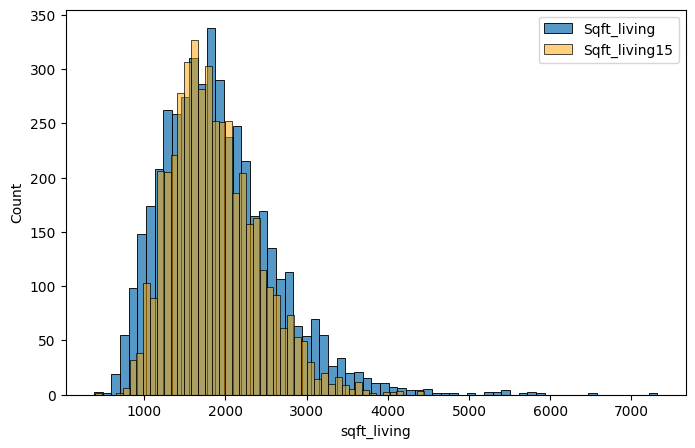

In [27]:
sns.histplot(data=sorted_sugg, x='sqft_living',  label='Sqft_living')
sns.histplot(data=sorted_sugg, x='sqft_living15',  label='Sqft_living15', color='orange', alpha = 0.5)

plt.legend()
plt.show()

In [28]:
iqr_filtered = sorted_sugg.loc[iqr.index]

Our client wants to keep costs low, therefore we do not wish them to buy are property that needs significant renovations. We are filtering further for flats either built or renovated within the last 20 years (we assume that the dataset is produced in 2016 as the entries are up to 2015).

In [29]:
condition1 = (iqr_filtered['yr_renovated'] != 0) & ((iqr_filtered['yr_renovated'] - iqr_filtered['yr_renovated']) < 20)
condition2 = (iqr_filtered['yr_renovated'] == 0) & (iqr_filtered['yr_built'] >= 1996)
renovation = iqr_filtered[condition1 | condition2]

Dataframe with all recommendations after filtering. We allow for a subset of price per square foot lower than the overall median, so that the client can decide according to their budget.

In [30]:
all_recommendations = renovation[renovation['price_per_sqft']<clean_df['price_per_sqft'].median()]

In [31]:
all_recommendations.shape

(436, 21)

We end up with 436 recommended properties, from which the client can chose according to their own criteria from the map below.

In [32]:
rennovated_properties = px.scatter_mapbox(all_recommendations, lat='lat', lon='long',  zoom=8,
color = 'price_per_sqft',
size='grade',
size_max=10)
rennovated_properties.update_layout(mapbox_style= "carto-positron")
rennovated_properties.show()

If this wide range of choices is overwhelming for the client, we can narrow it down to 14 suggestions by randomly picking one location per zipcode.

In [33]:
random_picks =  all_recommendations.groupby('zipcode').sample(n=1, random_state=1)
random_picks

,price,price_per_sqft,sqft_living,grade,condition,center_distance,bedrooms,bathrooms,floors,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_built,yr_renovated,sold_date,zipcode,house_id,lat,long
13276,270000,149,1808,8,3,24.061,3,2.500,1.000,19200,1808,0,1450,14400,2005,0,2014-09-17,98001,3750605674,47.260,-122.281
20007,240000,162,1481,7,3,19.225,3,2.250,2.000,2820,1481,0,1481,3028,2012,0,2014-06-25,98002,301402120,47.346,-122.217
17015,275000,160,1710,7,3,22.697,3,2.500,2.000,7230,1710,0,1720,6537,1996,0,2015-04-21,98003,1150700130,47.278,-122.298
13668,295000,175,1677,7,3,21.174,4,2.500,2.000,7209,1677,0,2236,7209,2011,0,2015-03-26,98023,7503800210,47.296,-122.357
6368,251100,140,1790,7,3,17.044,4,2.500,2.000,5257,1790,0,1680,5320,1996,0,2014-12-09,98030,8662500130,47.385,-122.204
7049,307550,155,1980,8,3,17.106,4,2.500,2.000,5909,1980,0,2550,5487,2003,0,2014-06-09,98031,1541700170,47.391,-122.185
8199,249000,142,1752,8,3,16.317,3,1.000,2.000,14626,1752,0,1800,9000,2005,0,2014-12-02,98032,2895110062,47.376,-122.278
13233,293500,182,1610,7,3,21.733,3,2.500,2.000,5024,1610,0,1790,3717,2004,0,2015-03-27,98038,4142450040,47.383,-122.043
21404,299950,172,1740,7,3,20.138,3,2.500,2.000,4497,1740,0,1950,4486,2012,0,2015-03-03,98042,9478550110,47.370,-122.117
20084,307000,179,1714,8,3,14.868,4,2.500,2.000,3080,1714,0,1714,3250,2009,0,2014-07-10,98055,6817750110,47.429,-122.188


In [34]:
final_suggestion = px.scatter_mapbox(random_picks, lat='lat', lon='long',  zoom=8,
color = 'price_per_sqft',
hover_data = ['price', 'sqft_living', 'bedrooms','bathrooms','floors', 'condition'],
size='grade',
size_max=10)
final_suggestion.update_layout(mapbox_style= "carto-positron")
final_suggestion.show()

## 5. Profit Margins

Our client does not want to make significant profit but we still want to identify the profit margins in order to advise them. Within the data in our selected area, there is a subset of 99 entries that are properties bought and sold from within a year. 

In [35]:
resold = suggestions_df[suggestions_df.duplicated(subset=['house_id'], keep=False)].groupby('house_id').apply(lambda x: x.reset_index(drop=True))

In [36]:
resold['sold_year'] = resold['sold_date'].dt.year

Plotting an overview of the bought vs sold prices for each of these properties

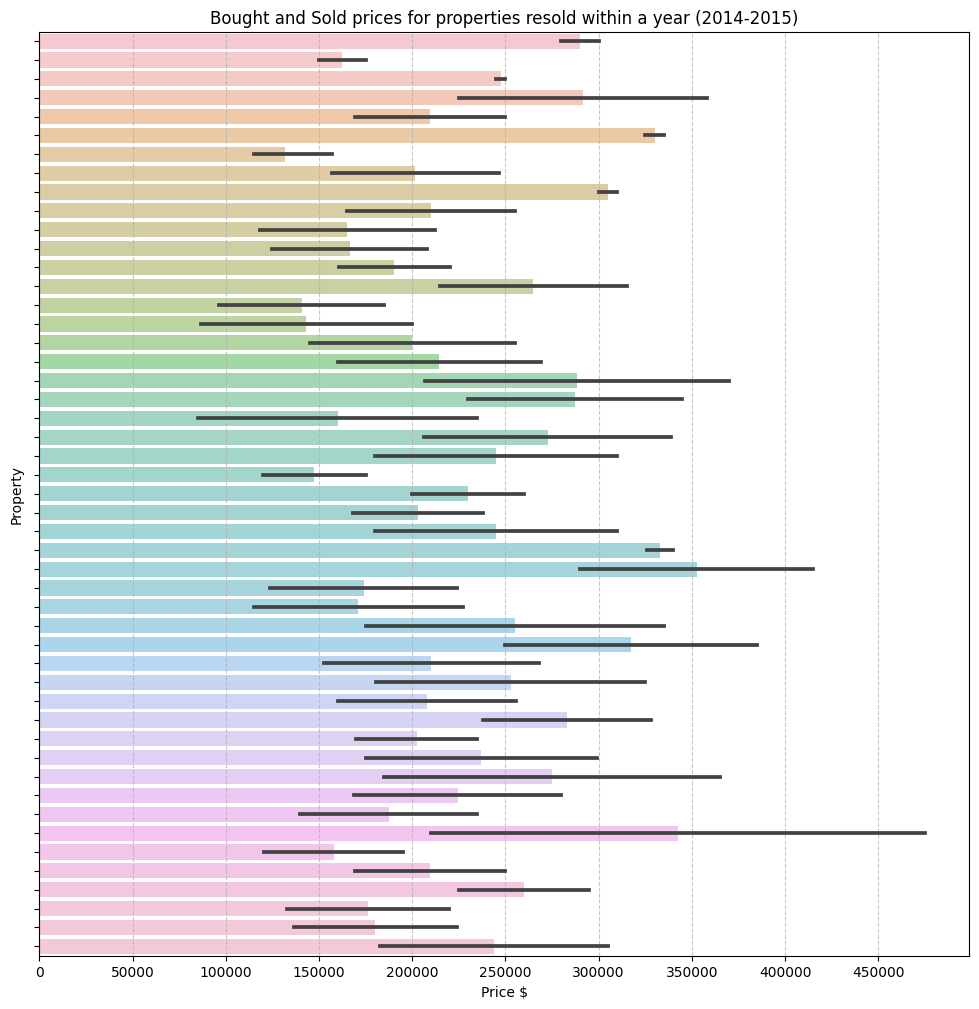

In [37]:
plt.figure(figsize=(12, 12))
sns.barplot(
    data=resold,
   y='house_id', x='price', orient='h', alpha=0.5 )
plt.xticks(np.arange(0, 500000, step=50000))      
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().set_yticklabels([])
plt.gca().set_ylabel('Property')
plt.gca().set_xlabel('Price $')
plt.title('Bought and Sold prices for properties resold within a year (2014-2015)')
plt.show()

For a value that we can use to compare each profit, we extract the profit ratio:

profit_ratio = (price15-price14) / {price2014}

In [38]:
price_bought= resold.loc[(slice(None), 0), 'price'].droplevel(1)
price_sold= resold.loc[(slice(None), 1), 'price'].droplevel(1)
profit = price_sold - price_bought

In [39]:
profit_ratio= (profit/price_bought)*100
profit_ratio.describe()

count    49.000
mean     59.445
std      34.037
min       2.041
25%      41.667
50%      61.491
75%      75.705
max     176.471
Name: price, dtype: float64

Text(0.5, 1.0, 'Profit Ratio Distribution')

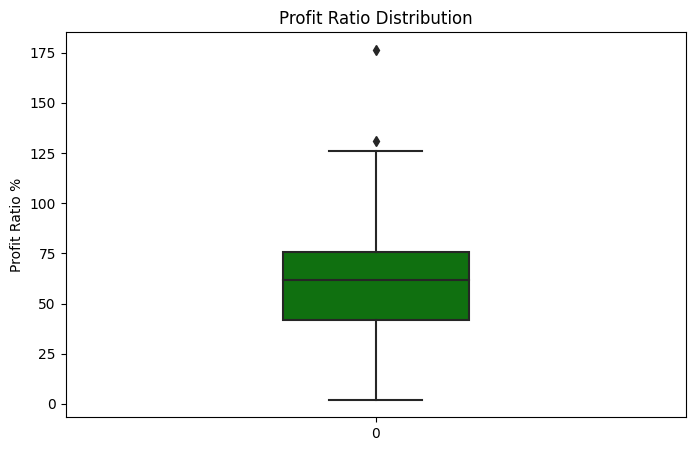

In [40]:
sns.boxplot(data=profit_ratio.reset_index(drop=True), color='green', width=0.3)
plt.gca().set( ylabel='Profit Ratio %')
plt.gca().set_title('Profit Ratio Distribution')

The profit ratio is quite high, with a mean of 60%. Possibly the flats that are resold within a year are result of speculative market. 

We could recommend our client to aim for a profit ratio up to the first quartile (41%), if they would wish to be fair but also protecting their interests.